## SVM

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
housing_price = pd.read_csv("kc_house_data.csv")

## 전처리
df_preprocessed = housing_price.drop(["id", "date", "price"], axis = 1)\
.assign(date = pd.to_datetime(housing_price.date)).assign(price = housing_price.price)

## scores recoding
scoring_dict = dict()

In [3]:
def month_days_split(df_train : pd.DataFrame, df_test : pd.DataFrame) :
    """
    train/test set에서 `date` 열을 월별과 일별로 따로 분석하기 위한 함수
    """
    test_month = df_test.date.dt.month.astype(str)
    test_days = df_test.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    train_month = df_train.date.dt.month.astype(str)
    train_days = df_train.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    
    return [train_month, train_days], [test_month, test_days]

df_train, df_test = train_test_split(df_preprocessed, test_size = 0.3, shuffle = True, random_state = 14107)
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

train_date, test_date = month_days_split(df_train, df_test)

In [4]:
import matplotlib.pyplot as plt

`-` XGBoost와의 비교

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from skopt import BayesSearchCV
import xgboost as xgb

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [18]:
## data
X = df_train[["long", "lat"]]
y = df_train.price.map(lambda x : x >= df_train.price.median()).astype(int)

XX = df_test[["long", "lat"]]
yy = df_test.price.map(lambda x : x >= df_train.price.median()).astype(int)

## params
fit_params = {
    'early_stopping_rounds': 10, ## 성능 개선이 없을 시 종료 라운드
    'verbose': False
}

search_space = {
    'learning_rate': (0.001, 0.1), ## 학습률
    'n_estimators': (300, 1500), ## 트리 수
    'gamma': (1e-3, 10, "log-uniform"), ## 노드 분할 시 최소 손실 감소량
    'max_depth': (1, 15), ## 트리 깊이
    'min_child_weight': (1e-4, 10, "log-uniform"), ## 헤시안의 최소값
    # 'colsample_bytree': (0.2, 0.7), ## 설명변수 두개밖에 없는데 열을 서브샘플링 하긴 좀 그럼
    'subsample': (0.5, 1.0), ## 데이터 서브 샘플링
    'sampling_method': ["uniform", "gradient_based"], ## 서브 샘플링 방법
    'lambda': (1e-3, 100, "log-uniform"), ## 가중치 L2 표준화 계수
    'alpha': (1e-4, 10, "log-uniform") ## 가중치 L1 표준화 계수
}

kfold = KFold(5, random_state = 14107, shuffle = True)

## optimizr
predictr = xgb.XGBClassifier(tree_method = "gpu_hist", device = "cuda")
optimizr = BayesSearchCV(
    estimator=predictr,
    search_spaces=search_space,
    fit_params=fit_params,
    cv=kfold,
    scoring="accuracy",
    random_state=14107,
    verbose=1
)

optimizr.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=KFold(n_splits=5, random_state=14107, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device='cuda',
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=No...
              random_state=14107, scoring='accuracy',
              search_spaces={'alpha': (0.0001, 10, 'log-uniform'),
                             'gamma': (0.001, 10, 'log-uniform'),
                             'lambda': (0.001, 100, 'log-uniform'),
                             'learning_rate': (0.001, 0.1),
                             'max_depth': (1, 15),
                             'min_child_weight': (0.0001, 10, 'log-uniform'),
                             'n_estimators': (300, 1500),
                             'sampling_method': ['uniform', 'gradient_based'],
                             'subsample': (0.5, 1.0)},
              verbose=1)

In [17]:
tmp = optimizr.best_estimator_.get_params()

In [19]:
## best parameter set 확인
# print(optimizr.best_estimator_.get_params())

## rmse 계산
best_predictr = xgb.XGBClassifier(**optimizr.best_estimator_.get_params())
best_predictr.fit(X, y)

XGBClassifier(alpha=0.005418217261000339, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.001, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=11.349650924826634,
              learning_rate=0.005482807743015436, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=0.29019204468163284, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1308,
              n_jobs=None, ...)

In [20]:
yyhat = best_predictr.predict(XX)
print(confusion_matrix(yyhat, yy))
print(f"accuracy = {np.mean(yy == yyhat)}")

[[2706  457]
 [ 513 2808]]
accuracy = 0.850400987045034


In [22]:
import matplotlib.pyplot as plt

In [26]:
from sklearn.svm import SVC

In [28]:
best_svm = SVC(kernel = "rbf", C = 10000, gamma = 1000)
best_svm.fit(X, y)

SVC(C=10000, gamma=1000)

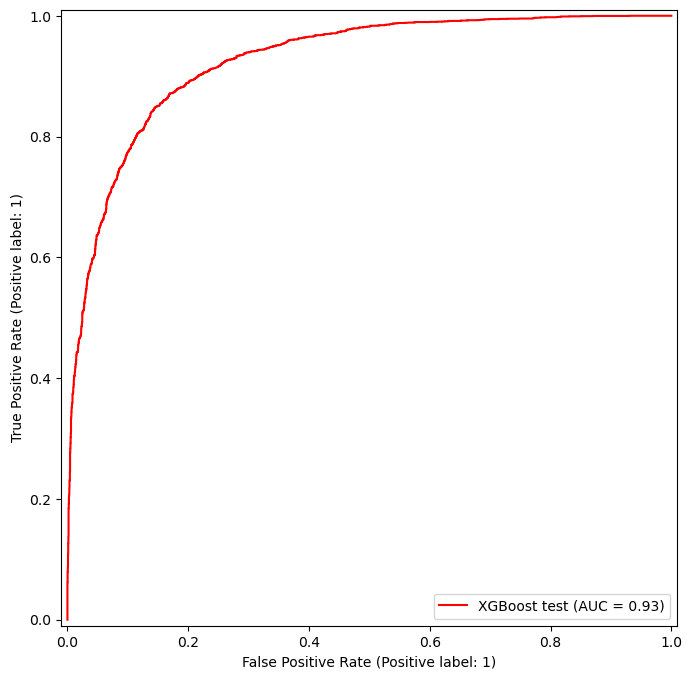

In [24]:
roc_curve = RocCurveDisplay.from_estimator

fig, ax = plt.subplots(figsize=(8,8))
roc_curve(best_predictr, XX, yy, name='XGBoost test', color='r', ax=ax)
fig.show()

In [36]:
yyhat = best_svm.predict(XX)
print(confusion_matrix(yyhat, yy))
print(f"accuracy = {np.mean(yy == yyhat)}")

[[2655  482]
 [ 564 2783]]
accuracy = 0.8386798272671191


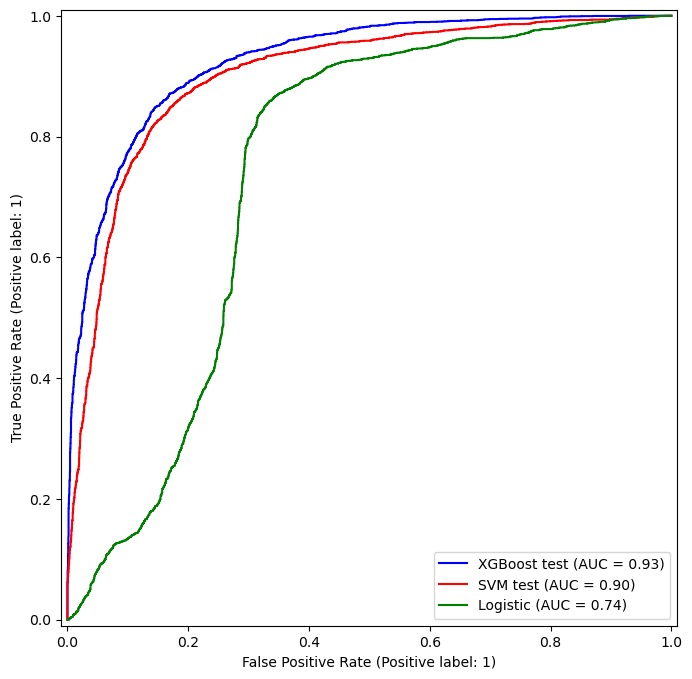

In [33]:
fig, ax = plt.subplots(figsize = (8,8))
roc_curve(best_predictr, XX, yy, name = "XGBoost test", color = "b", ax = ax)
roc_curve(best_svm, XX, yy, name = "SVM test", color = "red", ax = ax)
roc_curve(logit_model, XX, yy, name = "Logistic", color = "green", ax = ax)
fig.show()

In [30]:
import sklearn.linear_model

In [31]:
logit_model = sklearn.linear_model.LogisticRegression()
logit_model.fit(X, y)

LogisticRegression()

In [32]:
yyhat = logit_model.predict(XX)
print(confusion_matrix(yyhat, yy))
print(f"accuracy = {np.mean(yy == yyhat)}")

[[2244  655]
 [ 975 2610]]
accuracy = 0.7486119679210363


In [ ]:
roc_curve(svm_flex, X_test ,
y_test, name='Test $\gamma=50$', color='b', ax=ax)
fig, ax = subplots(figsize=(8,8))
for (X_, y_, c, name) in zip(
(X_train, X_test), (y_train, y_test),
('r', 'b'),
('CV tuned on training',
'CV tuned on test')):
    roc_curve(best_svm, X_, y_, name=name, ax=ax, color=c)

In [ ]:
import pickle

with open("best_svm.pkl", "wb") as f :
    pickle.dump(best_predictr, f)